## stacking 集成算法

In [2]:
# 导入必要的工具包
import numpy as np #用于数值计算
import pandas as pd #用于数据表处理，数据文件读写
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV

import matplotlib.pyplot as plt #用于绘图：分析结果的可视化。
import seaborn as sns #用于绘图：分析结果的可视化。封装更好。
from IPython.display import display

#应该是设置浮点数的形式格式，小数点后三位
pd.set_option('display.float_format', lambda x: '%.4f' % x)

#这一行是干嘛的？ 设置 matplotlib 让绘制的图形出现在 Notebook 里而不是新窗口
%matplotlib inline

In [8]:
Y_Standard = True
# 生成的结果文件名称
out_name = '%ssummit=0.1-encoder=16-%s.csv'
path_train = '../data/new/train=all/'
path_test = '../data/new/test/'
summit_path = '../data/summit/'
train_part_num = 5 #训练集拆分个数

In [13]:
# 读取数据
val_id = 1 #当前校验集编号
init_id = (val_id % 5) + 1
df_train = pd.read_csv('%strain=fe-%s.csv' % (path_train, init_id))

for i in range(train_part_num):
    cur_id = i + 1
    if cur_id == val_id:
        df_val = pd.read_csv('%strain=fe-%s.csv' % (path_train, val_id))
    elif not cur_id == init_id:
        df_train = pd.concat([df_train, pd.read_csv('%strain=fe-%s.csv' % (path_train, cur_id))])

print('df_train.shape=%s  df_val.shape=%s'% (df_train.shape, df_val.shape))

TypeError: not all arguments converted during string formatting

df_train.shape=(1830404, 109)  df_val.shape=(457602, 109)


In [4]:
test = pd.read_csv(path_test + 'tap_fun_test-fe.csv')
test.head()

,user_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,14933,0.9992,0.9952,0.9816,0.0184,0.2460,0.9982,0.9020,0.9876,0.9503,0.0293,0.0005,0.9991,0.0286,0.6675,1.0000,0.9188
1,14934,0.9966,0.9983,0.0388,0.9942,0.8734,0.9871,0.9989,0.9942,0.9849,0.0081,0.6787,0.8942,0.0038,0.0209,0.9998,0.9930
2,14935,0.9985,0.9994,0.0254,0.9820,0.8951,0.9873,0.9970,0.9928,0.9768,0.0089,0.5385,0.9404,0.0096,0.0275,0.9999,0.9810
3,14936,0.9989,0.9961,0.0531,0.9955,0.8362,0.9843,0.9985,0.9918,0.9864,0.0064,0.6846,0.7807,0.0026,0.0358,0.9999,0.9903
4,14937,0.9972,0.9989,0.0384,0.9820,0.9284,0.9858,0.9979,0.9950,0.9750,0.0053,0.6409,0.9358,0.0074,0.0178,0.9999,0.9833


In [5]:
# 从原始数据中分离输入特征x和输出y
target = 'prediction_pay_price'
id = 'user_id'
train_y = train[target].values
train_X = train.drop([target, id], axis = 1)

# test_id = test[id]
test_X = test.drop([id], axis = 1)

In [6]:
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(train_X, train_y, random_state=33, test_size=0.1)
print('train.shape=%s X_train_part.shape=%s X_test_part.shape=%s'
      %(train.shape, X_train_part.shape, X_val_part.shape))

train.shape=(228800, 18) X_train_part.shape=(205920, 16) X_test_part.shape=(22880, 16)


## 数据标准化

In [12]:
# 分别初始化对特征和目标值的标准化器
ss_X = StandardScaler()
ss_y = StandardScaler()

# 分别对训练和测试数据的特征以及目标值进行标准化处理
X_train_part = ss_X.fit_transform(X_train_part)
X_val_part= ss_X.transform(X_val_part)
test_X = ss_X.transform(test_X)

if Y_Standard:
    y_train_part = ss_y.fit_transform(y_train_part.reshape(-1, 1))
    y_val_part = ss_y.transform(y_val_part.reshape(-1, 1))

# 需要转换为一维数组 
y_train_part_1d = y_train_part.reshape(y_train_part.shape[0])
y_val_part_1d = y_val_part.reshape(y_val_part.shape[0])

In [8]:
# 标准化数据还原 
def inverse_StandardScaler(predict):
    if Y_Standard:
        predict = ss_y.inverse_transform(predict)
        print('predict = ', predict)
    return predict

#输出预测后的数据
def generate_summit(predict):
    testPredict = test.copy()
    testPredict[target] = predict
    testPredict = testPredict[[id,target]]
    testPredict[target] = testPredict[target].apply(lambda x: x if x > 0 else 0)
    return testPredict

# def move_up(predict):
#     # 预测值里面的最小值
#     pred_min = np.min(predict)
#     if pred_min < 0:
#     #     如果是负数，则整体上移，效果不好 
#         predict = predict - pred_min
#     print('pred_min=%s'%pred_min)
#     return predict

## 模型训练
### 1.正则化的线性回归（L1正则 --> Lasso）

In [32]:
%%time
#正则项系数
# alphas = [0.1, 10, 100, 1000, 10000, 10000]
alphas = [0.00000001, 0.00001, 0.0004, 0.0005,0.00051,0.00052,0.00053,0.00054,0.00055,0.0006, 0.001, 1]

# Lasso 模型实例
lasso = LassoCV(alphas=alphas)
#进行模型训练
lasso.fit(X_train_part, y_train_part_1d)

Wall time: 584 ms


best alpha is: 0.0005


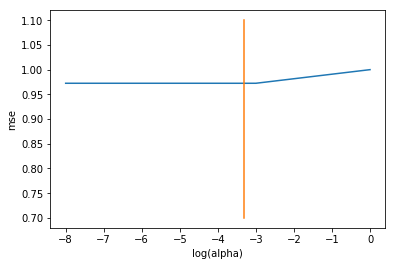

In [33]:
## 3.1 Lasso 模型评价
mses = np.mean(lasso.mse_path_, axis=1)

#plt.plot(np.log10(alphas), mses)
plt.plot(np.log10(lasso.alphas_), mses)
# plt.show()  #绘制在一张图上，显示异常，暂时分开 

plt.plot(np.log10(lasso.alpha_)*np.ones(3), [0.7, 0.9, 1.1])
plt.xlabel('log(alpha)')
plt.ylabel('mse')
# plt.show() 
print ('best alpha is:', lasso.alpha_)
# best alpha is: 10.5

In [34]:
# 模型评估
lassoScoreTrain = lasso.score(X_train_part, y_train_part)
lassoScoreVal = lasso.score(X_val_part, y_val_part)
print('The score: Train=%s  Val=%s'% (lassoScoreTrain, lassoScoreVal)) 

lasso_predict_train = lasso.predict(X_train_part)
rmseTrain = mean_squared_error(y_train_part, lasso_predict_train) ** 0.5
lasso_predict_val = lasso.predict(X_val_part)
rmseVal = mean_squared_error(y_val_part, lasso_predict_val) ** 0.5
print('The RMSE: Train=%s  Val=%s' % (rmseTrain, rmseVal))

# The score: Train=0.6026498641616385  Val=0.8354317552131078
# The RMSE: Train=0.6303571494306712  Val=0.5921995943739873

The score: Train=0.029444136814204658  Val=0.018811488029750523
The RMSE: Train=0.985167936539652  Val=1.4460100599107082


In [35]:
#对测试数据进行预测
lasso_y_predict_test = lasso.predict(test_X)
print('lasso_y_predict_test = ', lasso_y_predict_test)

# 标准化数据还原 
lasso_y_predict_test = inverse_StandardScaler(lasso_y_predict_test)
# lasso_y_predict_test =  [0.4556051 0.4556051 0.4556051 ... 0.4556051 0.4556051 0.4556051]

lasso_y_predict_test =  [ 0.00665733  0.00493644  0.00183505 ... -0.03143557 -0.00196485
 -0.00211317]
predict =  [ 1.98895125  1.87989976  1.68336596 ... -0.42497637  1.4425684
  1.43316945]


In [36]:
testPredict = generate_summit(lasso_y_predict_test)
#输出预测后的数据
testPredict.to_csv(out_name %(summit_path, 'lasso'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,1.9890
1,14934,1.8799
2,14935,1.6834
3,14936,1.8447
4,14937,2.2409


## 2 正则化的线性回归（L2正则 --> 岭回归）

In [49]:
%%time
#正则项的参数
# alphas = [0.01, 0.1, 1, 10, 100, 10000]
alphas = [0.1, 100,1200,1290,1300,1310,1400, 10000, 100000]

#创建岭回归模块实例
ridge = RidgeCV(alphas=alphas, store_cv_values=True)
#进行模型训练
ridge.fit(X_train_part, y_train_part)

Wall time: 709 ms


best alpha is: 1310.0


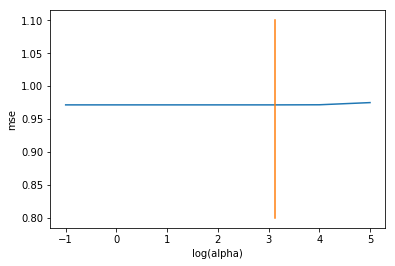

In [50]:
### 2.1 岭回归模型评价
mse_mean = np.mean(ridge.cv_values_, axis=0)

#正则项参数取对数， mse_mean.reshape() 干什么的？拉平
plt.plot(np.log10(alphas), mse_mean.reshape(len(alphas), 1))
# 在最佳参数位置绘制竖线：注意第二个参数值要和 Y 坐标轴匹配
plt.plot(np.log10(ridge.alpha_)*np.ones(3), [.8, .9, 1.1])
# plt.show() #绘制在一张图上，显示异常，暂时分开 

plt.xlabel('log(alpha)')
plt.ylabel('mse')

print('best alpha is:', ridge.alpha_)

In [51]:
# 模型评估
ridgeScoreTrain = ridge.score(X_train_part, y_train_part)
ridgeScoreVal = ridge.score(X_val_part, y_val_part)
print('The score: Train=%s  Val=%s'% (ridgeScoreTrain, ridgeScoreVal)) 

ridge_predict_train = ridge.predict(X_train_part)
rmseTrain = mean_squared_error(y_train_part, ridge_predict_train) ** 0.5
ridge_predict_val = ridge.predict(X_val_part)
rmseVal = mean_squared_error(y_val_part, ridge_predict_val) ** 0.5
print('The RMSE: Train=%s  Val=%s' % (rmseTrain, rmseVal))

#The score: Train=0.5949662293458398  Val=0.7221624627853553
# The RMSE: Train=0.6364226352465477  Val=0.7694679714355298

The score: Train=0.029458404637585978  Val=0.018836919984246192
The RMSE: Train=0.9851606951976993  Val=1.4459913198317655


In [52]:
#对测试数据进行预测
ridge_y_predict_test = ridge.predict(test_X)
print('ridge_y_predict_test = ', ridge_y_predict_test)

# 标准化数据还原 
ridge_y_predict_test = inverse_StandardScaler(ridge_y_predict_test)

ridge_y_predict_test =  [[ 0.00739914]
 [ 0.00648584]
 [ 0.00177439]
 ...
 [-0.04709092]
 [-0.00033277]
 [-0.00055999]]
predict =  [[ 2.03595939]
 [ 1.97808435]
 [ 1.679522  ]
 ...
 [-1.4170482 ]
 [ 1.54599228]
 [ 1.53159362]]


In [53]:
# ridge_y_predict_test = move_up(ridge_y_predict_test)
#输出预测后的数据
testPredict = generate_summit(ridge_y_predict_test)
#输出预测后的数据
testPredict.to_csv(out_name %(summit_path, 'RidgeCV'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,2.0360
1,14934,1.9781
2,14935,1.6795
3,14936,2.0127
4,14937,2.2729


### 3. 正则化的线性回归 ElasticNetCV 

In [63]:
%%time
# l1_ratio = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
l1_ratio = [.1, .5, .7, .9, .95, .99, 1]
# Lasso 模型实例
elastic_net = ElasticNetCV(l1_ratio=l1_ratio, eps=0.001, n_jobs=-1)

#进行模型训练
y_train_part_1d = y_train_part.reshape(y_train_part.shape[0])
elastic_net.fit(X_train_part, y_train_part_1d)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Wall time: 14.7 s


best alpha is:0.06755166083756958  l1_ratio_:1.0


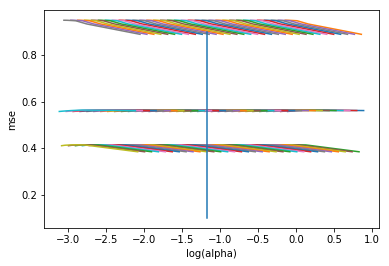

In [65]:
## 3.1 Lasso 模型评价
mses = np.mean(elastic_net.mse_path_, axis=1)

#plt.plot(np.log10(alphas), mses)
plt.plot(np.log10(elastic_net.alphas_), mses)
# plt.show()  #绘制在一张图上，显示异常，暂时分开 

plt.plot(np.log10(elastic_net.alpha_)*np.ones(3), [0.1, 0.5, .9])
plt.xlabel('log(alpha)')
plt.ylabel('mse')
# plt.show() 

print ('best alpha is:%s  l1_ratio_:%s' % (elastic_net.alpha_, elastic_net.l1_ratio_))
# best alpha is:1.853019181787895  l1_ratio_:0.1

In [66]:
# 模型评估
elastic_netScoreTrain = elastic_net.score(X_train_part, y_train_part)
elastic_netScoreVal = elastic_net.score(X_val_part, y_val_part)
print('The score of ElasticNet: Train=%s  Val=%s'% (elastic_netScoreTrain, elastic_netScoreVal)) 

elastic_net_predict_train = elastic_net.predict(X_train_part)
rmseTrain = mean_squared_error(y_train_part, elastic_net_predict_train) ** 0.5
elastic_net_predict_val = elastic_net.predict(X_val_part)
rmseVal = mean_squared_error(y_val_part, elastic_net_predict_val) ** 0.5
print('The RMSE: Train=%s  Val=%s' % (rmseTrain, rmseVal))

# The score of ElasticNet: Train=0.5933701157431497  Val=0.6918598273465699
# The RMSE: Train=40.40916662890711  Val=51.351069750253906

The score of ElasticNet: Train=0.6252723535546627  Val=0.7812344063379026
The RMSE: Train=0.6121500195583901  Val=0.682785982774603


In [67]:
#对测试数据进行预测
elastic_net_predict_test = elastic_net.predict(test_X)
print('elastic_net_predict_test = ', elastic_net_predict_test)

# 标准化数据还原 
elastic_net_predict_test = inverse_StandardScaler(elastic_net_predict_test)

elastic_net_predict_test =  [-0.02091785 -0.0221065  -0.0221065  ... -0.02134954 -0.0221065
 -0.0221065 ]
predict =  [0.24152607 0.16620206 0.16620206 ... 0.21417011 0.16620206 0.16620206]


In [68]:
testPredict = generate_summit(elastic_net_predict_test)
#输出预测后的数据
testPredict.to_csv(out_name %(summit_path, 'ElasticNetCV'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,0.2415
1,14934,0.1662
2,14935,0.1662
3,14936,0.1662
4,14937,0.1662
